In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from iminuit import Minuit, cost
#mcfile = uproot.open("/dune/data/users/yinrui/MC0_211205/pduneana_MC.root:pduneana")
#datafile = uproot.open("/dune/data/users/yinrui/data_211203/pduneana_data.root:pduneana")
mcfile = uproot.open("/dune/app/users/yinrui/thinslice1/build/newtree_0714_muon_MC.root")
datafile = uproot.open("/dune/app/users/yinrui/thinslice1/build/newtree_0714_muon_data.root")

In [2]:
branches = ["beam_inst_P", "reco_beam_calo_startX", "reco_beam_calo_startY", "reco_beam_calo_startZ", "reco_beam_calo_endX", "reco_beam_calo_endY", "reco_beam_calo_endZ", "true_beam_startP", "reco_KE_from_trklen"]
momin = 0.7; momax = 1.3

fakedata = False

#mcevt = mcfile["beamana"].arrays(branches, "(event%2==1)")
mcevt = mcfile["beamana"].arrays(branches)
if fakedata:
    dataevt = mcfile["beamana"].arrays(branches, "(event%2==0)")
else:
    dataevt = datafile["beamana"].arrays(branches)

mcP = mcevt["beam_inst_P"]
mcP_true = mcevt["true_beam_startP"]
dataP = dataevt["beam_inst_P"]
reco_KE_data = dataevt["reco_KE_from_trklen"]
reco_KE_MC = mcevt["reco_KE_from_trklen"]

MC selected events: 1558 	Data selected events: 2698


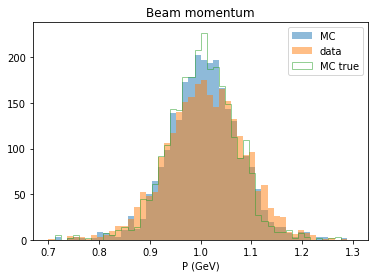

In [3]:
nmc = len(mcP); ndata = len(dataP)
print("MC selected events:", nmc, "\tData selected events:", ndata)
mcweight = np.ones_like(mcP)*ndata/nmc
#print("Cut:", precut + f" & (Beam Quality Cut)")

nnmc, xemc, _ = plt.hist(mcP, bins=50, alpha=0.5, label="MC", weights=mcweight, range=[momin,momax])
nndt, xedt, _ = plt.hist(dataP, bins=50, alpha=0.5, label="data", range=[momin,momax])
nnmc_t, xemc_t, _ = plt.hist(mcP_true, bins=50, alpha=0.5, label="MC true", weights=mcweight, range=[momin,momax], histtype="step")
plt.legend()
plt.title("Beam momentum")
plt.xlabel("P (GeV)")
plt.show()

In [4]:
def gauss_pdf(x, mu, sigma):
    return norm.pdf(x, mu, sigma)
def gauss_cdf(xe, mu, sigma):
    return norm.cdf(xe, mu, sigma)

#c1 = cost.UnbinnedNLL(mcP, gauss_pdf)
#c2 = cost.UnbinnedNLL(dataP, gauss_pdf)
#c3 = cost.UnbinnedNLL(mcP_true, gauss_pdf)
c1 = cost.BinnedNLL(nnmc, xemc, gauss_cdf)
c2 = cost.BinnedNLL(nndt, xedt, gauss_cdf)
c3 = cost.BinnedNLL(nnmc_t, xemc_t, gauss_cdf)

m1 = Minuit(c1, mu=1, sigma=0.07)
m1.migrad()
mu0inst = m1.values["mu"]
sigma0inst = m1.values["sigma"]
print(f"MC fitted (mu, sigma) = ({mu0inst}, {sigma0inst})")

m2 = Minuit(c2, mu=1, sigma=0.07)
m2.migrad()
muu = m2.values["mu"]
sigmaa = m2.values["sigma"]
print(f"Data fitted (mu, sigma) = ({muu}, {sigmaa})") # data

m3 = Minuit(c3, mu=1, sigma=0.07)
m3.migrad()
mu0 = m3.values["mu"]
sigma0 = m3.values["sigma"]
print(f"MC true fitted (mu, sigma) = ({mu0}, {sigma0})") # MC true

MC fitted (mu, sigma) = (1.007175932968096, 0.0694881261835611)
Data fitted (mu, sigma) = (1.009001560073317, 0.07644357253068759)
MC true fitted (mu, sigma) = (1.0031953419820514, 0.0669145504342396)


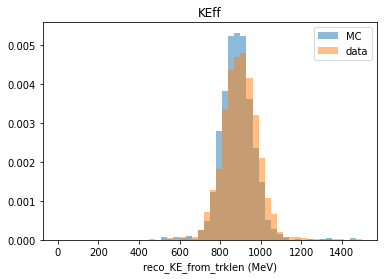

In [5]:
#MC_dXYZ = MCdistance[BQcut_MC]
#data_dXYZ = datadistance[BQcut_data]
MC_dXYZ = reco_KE_MC
data_dXYZ = reco_KE_data

plt.hist(MC_dXYZ,density=True,bins=50,alpha=0.5,label="MC", range=[0,1500])
plt.hist(data_dXYZ,density=True,bins=50,alpha=0.5,label="data", range=[0,1500])
plt.legend()
plt.title("KEff")
plt.xlabel("reco_KE_from_trklen (MeV)")
plt.show()

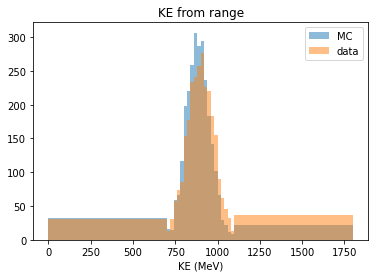

In [6]:
#dmin = 700; dmax = 1100
xbins = [0, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1800] # xbins for dXYZ Chi2 fit
nbins = len(xbins)-1
plt.hist(MC_dXYZ, bins=xbins, alpha=0.5, label="MC", weights=mcweight)
datahist, bin_edges, _ = plt.hist(data_dXYZ, bins=xbins, alpha=0.5, label="data")
plt.legend()
#plt.title("dXYZ")
#plt.xlabel("Distance (cm)")
plt.title("KE from range")
plt.xlabel("KE (MeV)")
plt.show()

wlimit = 1e-5
deno = np.exp(-(mcP_true - mu0)**2/2/sigma0**2)
deno = np.maximum(deno, wlimit)
#datahist, bin_edges = np.histogram(data_dXYZ, bins=nbins, range=[dmin, dmax])

def getChi2(mu=muu, sigma=sigmaa):
    numo = np.exp(-(mcP_true - mu)**2/2/sigma**2)
    numo = np.maximum(numo, wlimit)
    #print(sum(numo/deno))
    #print(len(numo/deno))
    normfact = len(numo)/sum(numo/deno)
    #print(normfact)
    weight = numo/deno * mcweight * normfact
    MChist, _ = np.histogram(MC_dXYZ, bins=xbins, weights=weight)
    chi2 = (datahist - MChist)**2/np.maximum(datahist + MChist, 1)
    return np.sum(chi2)/(nbins-1), weight

In [7]:
mu_list = np.linspace(1, 1.025, 100)
sigma_list = np.linspace(0.06, 0.08, 100)
mm, ss = np.meshgrid(mu_list, sigma_list)
Chi2 = np.zeros_like(mm)
for i in range(len(mm)):
    for j in range(len(mm[0])):
        Chi2[i,j], _ = getChi2(mm[i,j], ss[i,j])

Obtained mu = 1.01641 (res 0.00025)
Obtained sigma = 0.07111 (res 0.0002)


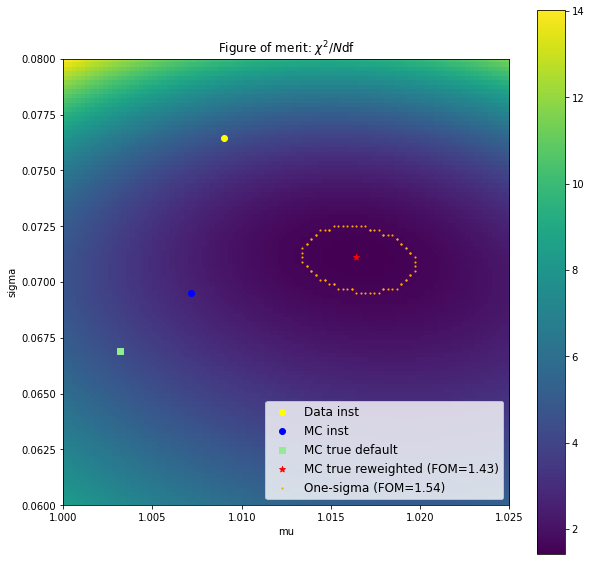

In [8]:
plt.figure(figsize=[10,10])
plt.imshow(Chi2,extent = [min(mu_list),max(mu_list),min(sigma_list),max(sigma_list)],origin="lower",aspect=(max(mu_list)-min(mu_list))/(max(sigma_list)-min(sigma_list)))
plt.colorbar()
plt.title(r"Figure of merit: $\chi^2/N{\rm df}$")
plt.xlabel("mu")
plt.ylabel("sigma")
plt.scatter([muu], [sigmaa], color="yellow", marker="o", label="Data inst")
plt.scatter([mu0inst], [sigma0inst], color="blue", marker="o", label="MC inst")
plt.scatter([mu0], [sigma0], color="lightgreen", marker="s", label="MC true default")
minChi2 = np.min(Chi2)
minidx = np.where(Chi2 == minChi2)
onesigmaChi2 = minChi2 + 2.30/(nbins-1) # Table 40.2 https://pdg.lbl.gov/2020/reviews/rpp2020-rev-statistics.pdf
onesigmaidx = []
for i in range(len(mm)):
    for j in range(len(mm[0])-1):
        if Chi2[i,j]>onesigmaChi2 and Chi2[i,j+1]<onesigmaChi2:
            onesigmaidx.append([i,j])
        if Chi2[i,j]<onesigmaChi2 and Chi2[i,j+1]>onesigmaChi2:
            onesigmaidx.append([i,j+1])
for i in range(len(mm)-1):
    for j in range(len(mm[0])):
        if Chi2[i,j]>onesigmaChi2 and Chi2[i+1,j]<onesigmaChi2:
            onesigmaidx.append([i,j])
        if Chi2[i,j]<onesigmaChi2 and Chi2[i+1,j]>onesigmaChi2:
            onesigmaidx.append([i+1,j])
mur = mm[minidx][0]
sigmar = ss[minidx][0]
print(f"Obtained mu = {mur:.5f} (res {np.average(mu_list[1:]-mu_list[:-1]):.2g})")
print(f"Obtained sigma = {sigmar:.5f} (res {np.average(sigma_list[1:]-sigma_list[:-1]):.2g})")
plt.scatter(mur, sigmar, color="r", marker="*", label=f"MC true reweighted (FOM={minChi2:.2f})")
plt.scatter(mm[tuple(np.transpose(onesigmaidx))], ss[tuple(np.transpose(onesigmaidx))], color="orange", marker=".", s=5, label=f"One-sigma (FOM={onesigmaChi2:.2f})")
plt.legend(fontsize=12, loc="lower right")
plt.show()

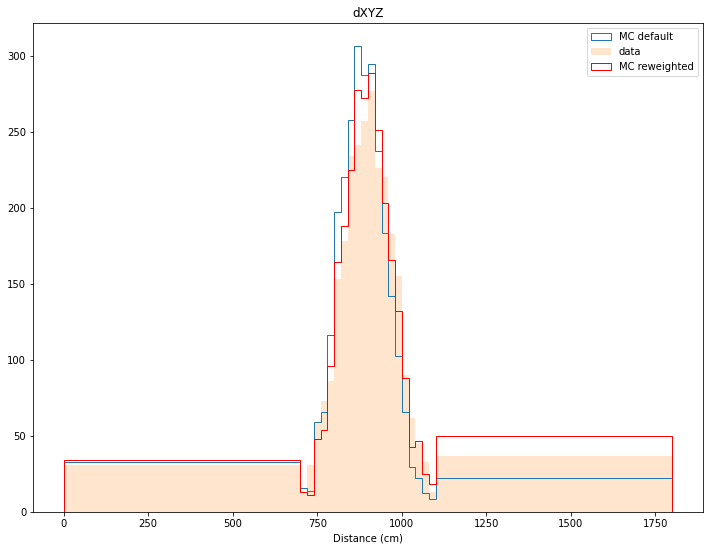

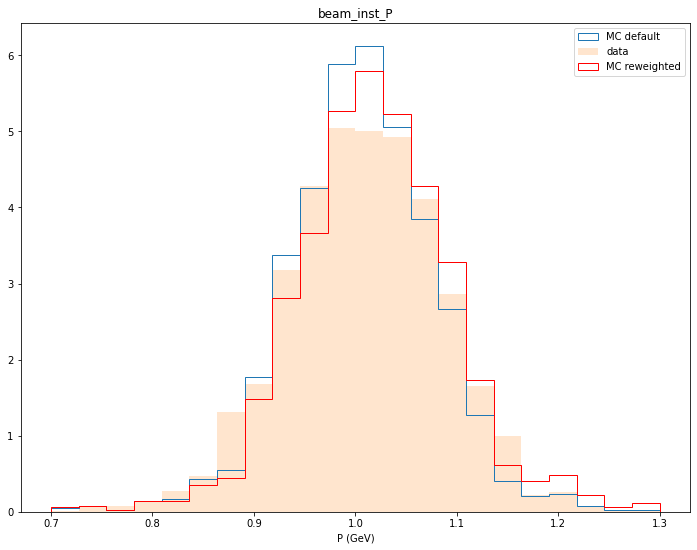

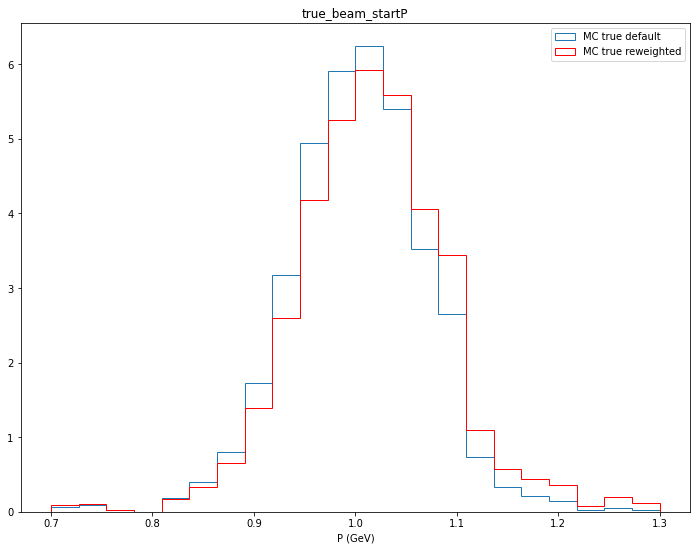

In [10]:
_, neweight = getChi2(mur, sigmar)
plt.figure(figsize=[12,9])
plt.hist(MC_dXYZ, bins=xbins, histtype="step", label="MC default", weights=mcweight)
plt.hist(data_dXYZ, bins=xbins, alpha=0.2, label="data")
plt.hist(MC_dXYZ, bins=xbins, histtype="step", label="MC reweighted", weights=neweight,color="r")
plt.legend()
plt.title("dXYZ")
plt.xlabel("Distance (cm)")
plt.show()

plt.figure(figsize=[12,9])
plt.hist(mcP, bins=nbins, histtype="step", label="MC default", weights=mcweight, range=[momin,momax], density=True)
plt.hist(dataP, bins=nbins, alpha=0.2, label="data", range=[momin,momax], density=True)
plt.hist(mcP, bins=nbins, histtype="step", label="MC reweighted", weights=neweight, range=[momin,momax],color="r", density=True)
plt.legend()
plt.title("beam_inst_P")
plt.xlabel("P (GeV)")
plt.show()

plt.figure(figsize=[12,9])
plt.hist(mcP_true, bins=nbins, histtype="step", label="MC true default", weights=mcweight, range=[momin,momax], density=True)
plt.hist(mcP_true, bins=nbins, histtype="step", label="MC true reweighted", weights=neweight, range=[momin,momax],color="r", density=True)
plt.legend()
plt.title("true_beam_startP")
plt.xlabel("P (GeV)")
plt.show()